In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [55]:
# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

sns.set(style="whitegrid")

In [56]:
df = pd.read_csv('shampoo_sales.csv',
                index_col='Month')

In [57]:
def custom_date_parser(date):
    year = 1981 + int(date.split('-')[0]) - 1
    month = int(date.split('-')[1])
    return pd.to_datetime(f'{year}-{month:02}')

In [58]:
df.index = df.index.to_series().apply(custom_date_parser)

In [59]:
df = df.to_period()

In [60]:
df.head()

,Sales
Month,
1981-01,266.0
1981-02,145.9
1981-03,183.1
1981-04,119.3
1981-05,180.3


## Fitting a linear regression model for Month feature

In [69]:
df['Month'] = np.arange(len(df.index))

In [70]:
# Training data
X = df.loc[:, ['Month']] # features
y = df.loc[:, 'Sales'] # target

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, shuffle=False)

# Train model
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [71]:
y_train_pred = pd.Series(model.predict(X_train), index=X_train.index)

In [72]:
y_test_pred = pd.Series(model.predict(X_test), index=X_test.index)

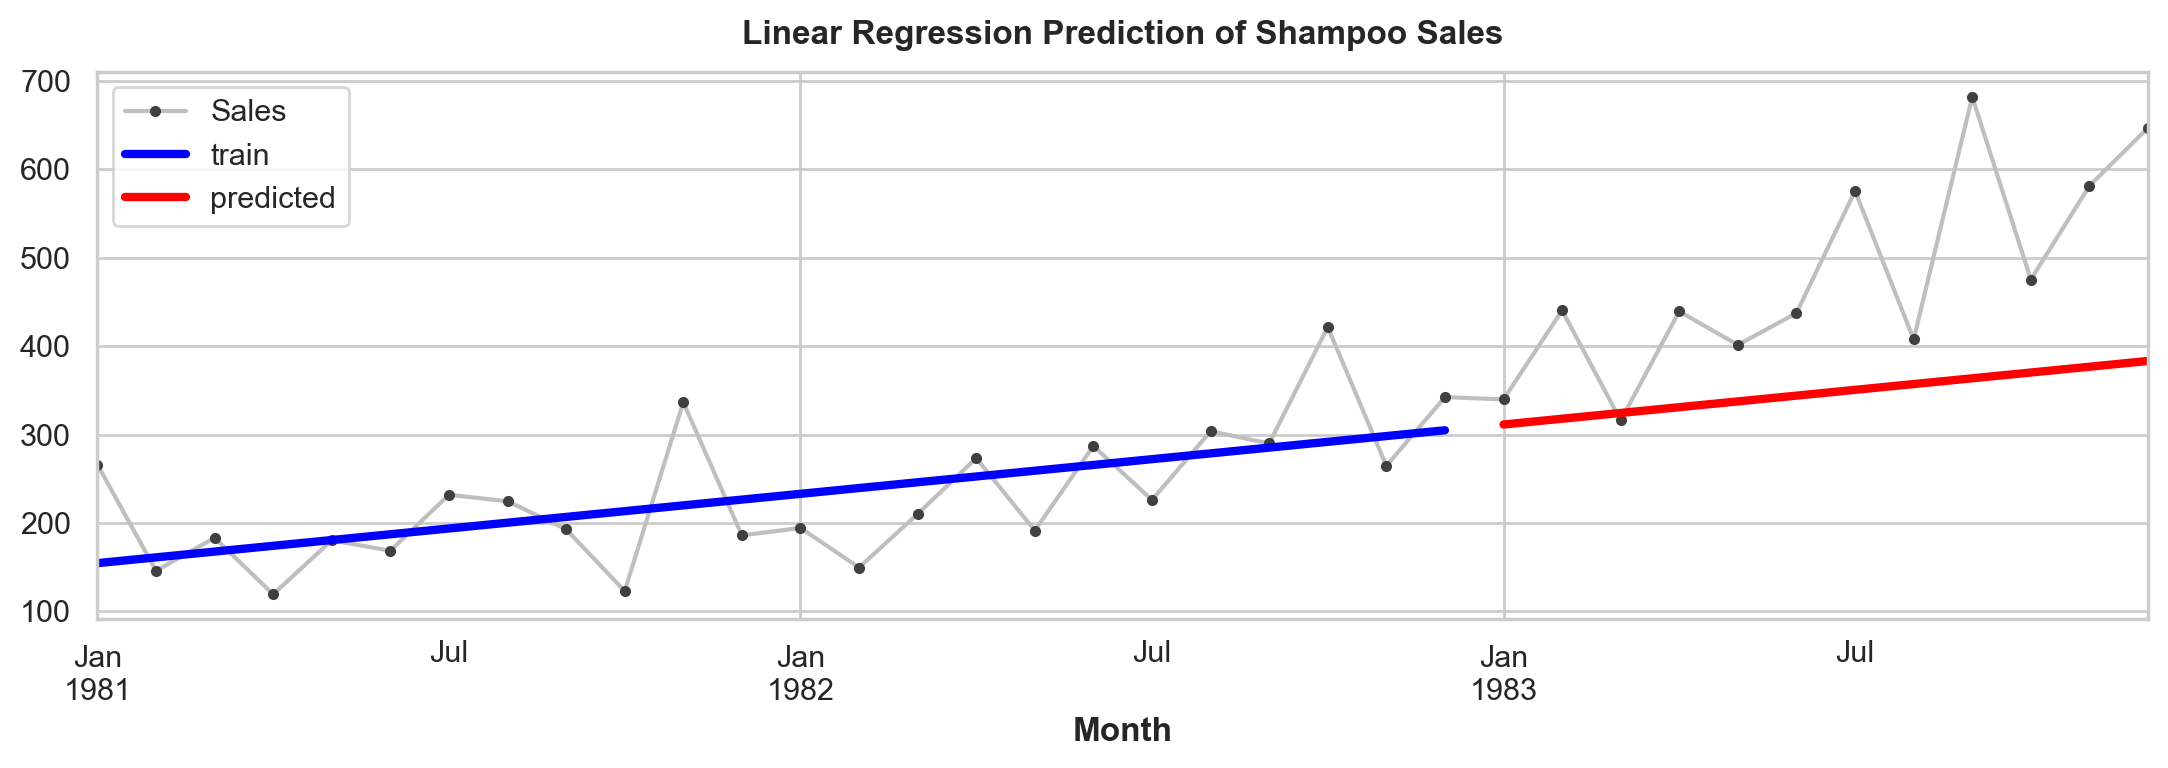

In [76]:
ax = y.plot(**plot_params)
ax = y_train_pred.plot(ax=ax, linewidth=3, color='blue', label='train')
ax = y_test_pred.plot(ax=ax, linewidth=3, color='red', label='predicted')
ax.set_title('Linear Regression Prediction of Shampoo Sales')
ax.legend();
plt.savefig('linear_regression_prediction.png')
plt.show()

In [78]:
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', mae)

Mean Absolute Error (MAE): 132.7094275362319
